<a href="https://www.kaggle.com/code/rishitjakharia/isruc-eda-modelling?scriptVersionId=215392825" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing

In [1]:
!pip install tsfel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 2.9 MB/s eta 0:00:00


In [2]:
import os
import re
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from scipy.signal import butter, filtfilt
import tsfel

#### Setting Seed for reproducability

In [3]:
import random
import os

seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## No. Exmaples Per Class
----
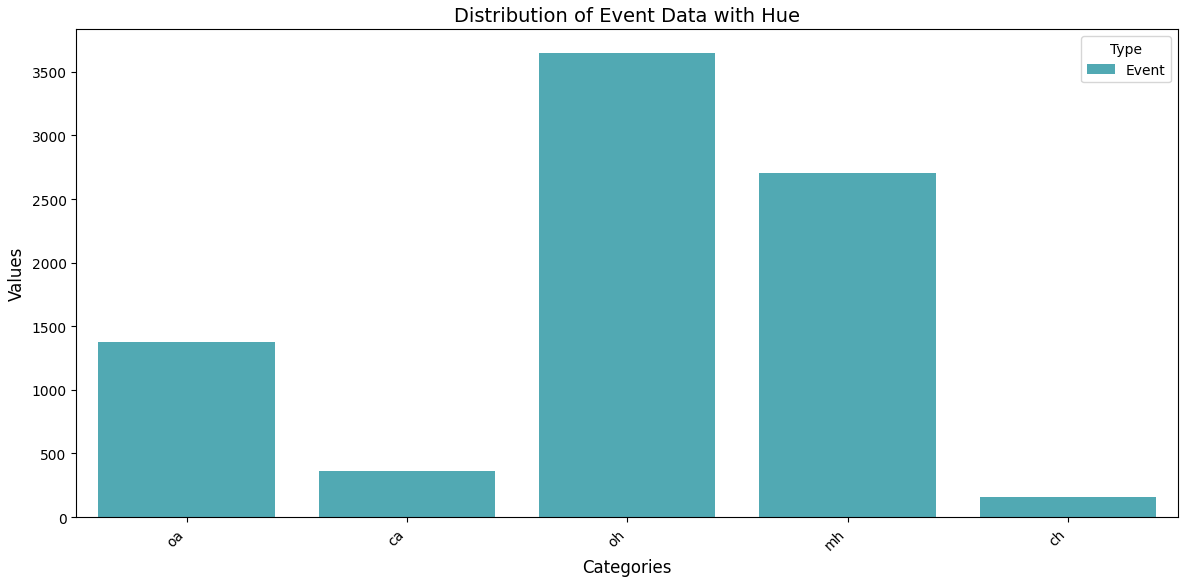

# Loading Data
----



In [4]:
class Normalization(object):
    def __init__(self, method="custom", axis=1, epsilon=1e-8):
        """
        Args:
            method (str): Normalization method ('z-score' or 'min-max').
            axis (int): Axis along which to normalize (0: samples, 1: channels).
            epsilon (float): Small constant to avoid division by zero.
        """
        self.method = method
        self.axis = axis
        self.epsilon = epsilon

    def __call__(self, signal):
        """
        Apply normalization to the signal.

        Args:
            signal (torch.Tensor): Signal tensor of shape (n_channels, n_samples).
        
        Returns:
            torch.Tensor: Normalized signal tensor of the same shape.
        """
        signal_np = signal.numpy() if isinstance(signal, torch.Tensor) else signal

        if self.method == "z-score":
            mean = np.mean(signal_np, axis=self.axis, keepdims=True)
            std = np.std(signal_np, axis=self.axis, keepdims=True) + self.epsilon
            normalized_signal = (signal_np - mean) / std
        elif self.method == "min-max":
            min_val = np.min(signal_np, axis=self.axis, keepdims=True)
            max_val = np.max(signal_np, axis=self.axis, keepdims=True) + self.epsilon
            normalized_signal = (signal_np - min_val) / (max_val - min_val)
        elif self.method == "min-max-zero-one":
            min_val = np.min(signal_np, axis=self.axis, keepdims=True)
            max_val = np.max(signal_np, axis=self.axis, keepdims=True) + self.epsilon
            normalized_signal = (signal_np) / (max_val - min_val)
        elif self.method == "custom":
            mean = np.mean(signal_np, axis=self.axis, keepdims=True)
            std = np.std(signal_np, axis=self.axis, keepdims=True) + self.epsilon
            
            min_val = np.min(signal_np[3])
            max_val = np.max(signal_np[3]) + self.epsilon
            normalized_signal = (signal_np - mean)/std
            normalized_signal[3] = (signal_np[3] - min_val)/(max_val-min_val)
        else:
            raise ValueError("Unsupported normalization method. Choose 'z-score' or 'min-max'.")

        return torch.tensor(normalized_signal, dtype=torch.float32)


class BandpassFilter(object):
    def __init__(self, fs, filters, order=4, padding_value=0):
        """
        Args:
            fs (float): Sampling frequency (Hz).
            order (int): Order of the filter.
            padding_value (float): Value to use for padding short signals.
        """
        self.fs = fs
        self.order = order
        self.padding_value = padding_value
        self.filters = filters

    def __call__(self, signal):
        """
        Apply the bandpass filter to the signal based on its index.

        Args:
            signal (np.ndarray): Signal array of shape (n_channels, n_samples).
        
        Returns:
            np.ndarray: Filtered signal of the same shape.
        """
        filtered_signal = []
        for i, channel in enumerate(signal):  # Iterate over channels
            lowcut, highcut = self.filters.get(i, (0.1, 0.5))  # Default to 0.1–0.5 Hz
            nyquist = 0.5 * self.fs
            low = lowcut / nyquist
            high = highcut / nyquist
            b, a = butter(self.order, [low, high], btype='band')
            
            # Pad and filter the channel
            if len(channel) <= self.order:
                padding_length = self.order - len(channel) + 1
                channel = np.pad(channel, (padding_length, padding_length), mode='constant', constant_values=self.padding_value)
            filtered_channel = filtfilt(b, a, channel)
            filtered_signal.append(filtered_channel)

        return np.array(filtered_signal)

## Sleep Stage Dataset

In [5]:
class SleepStageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Root directory containing all folders and signal files.
            transform (callable, optional): Optional transform to apply to the signals.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data_info = self._prepare_file_list()

    def _prepare_file_list(self):
        """Scan the dataset directory and prepare a list of file paths and labels."""
        data_info = []
        for event_type in ['Events', 'Non_Events']:
            folder_path = os.path.join(self.root_dir, event_type)
            if os.path.isdir(folder_path):
                for subfolder_name in os.listdir(folder_path):
                    subfolder_path = os.path.join(folder_path, subfolder_name)
                    if os.path.isdir(subfolder_path):
                        for file_name in os.listdir(subfolder_path):
                            # Full file path
                            file_path = os.path.join(subfolder_path, file_name)
                            # Extraxt sleep stage label from filename
                            label = file_name.split('_')[3].replace('Stage', '')
                            
                            # Ignore errorneous labels
                            if label not in ['w', 'n1', 'n2', 'n3', 'r']:
                                continue
                            
                            data_info.append((file_path, label))
                            
        return data_info

    def __len__(self):
        return len(self.data_info)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get file path and label
        file_path, label = self.data_info[idx]

        # converting label to one-hot
        label_to_one_hot = {
            'w':  [1,0,0,0,0],
            'n1': [0,1,0,0,0],
            'n2': [0,0,1,0,0],
            'n3': [0,0,0,1,0],
            'r':  [0,0,0,0,1],
        }
        label = label_to_one_hot[label]

        possible_columns = [
        ['X6', 'X7', 'X8', 'SaO2'],
        ['X6', 'X7', 'X8', 'SpO2'],
        ['29', '30', '31', 'SaO2'],
        ['29', '30', '31', 'SpO2']
        ]
        
        # Load signal data from .npy file
        signal = pd.read_csv(file_path)

        for columns in possible_columns:
            if all(col in signal.columns for col in columns):
                signal = signal[columns]
                break

        signal = torch.tensor(signal.values, dtype=torch.float32).T
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            for transform in self.transform:
                signal = transform(signal)

        return signal.T, label

In [10]:
root_dir = '/kaggle/input/isruc-processed/dataset'
filters = {
            0: (0.1, 0.5),  # AirFlow: 0.1–0.5 Hz
            1: (0.1, 0.5),  # Thoracic Respiration: 0.1–0.5 Hz
            2: (0.1, 0.5),  # Thoracic Respiration: 0.1–0.5 Hz
            3: (0.05, 2.0), # SpO2: 0.05–2.0 Hz
        }
transform = [BandpassFilter(fs=12.5, filters=filters), Normalization(method="custom", axis=1)]

sleep_stage_dataset = SleepStageDataset(root_dir=root_dir, transform=transform)
sleep_stage_loader = DataLoader(sleep_stage_dataset, batch_size=1, shuffle=False)

count = 5
for signals, labels in sleep_stage_loader:
    print(signals.shape)
    print(labels)
    if count == 0:
        break
    count -= 1

torch.Size([1, 375, 4])
tensor([[0, 0, 1, 0, 0]])
torch.Size([1, 375, 4])
tensor([[1, 0, 0, 0, 0]])
torch.Size([1, 375, 4])
tensor([[0, 0, 1, 0, 0]])
torch.Size([1, 375, 4])
tensor([[1, 0, 0, 0, 0]])
torch.Size([1, 375, 4])
tensor([[0, 0, 1, 0, 0]])
torch.Size([1, 375, 4])
tensor([[0, 0, 1, 0, 0]])


## Events classification dataset

In [6]:
class EventClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None, label_mapping=None, included_classes=None):
        """
        Args:
            root_dir (str): Root directory containing all folders and signal files.
            transform (callable, optional): Optional transform to apply to the signals.
            included_classes (list, optional): List of classes to include. If None, include all classes.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.included_classes = included_classes
        self.label_mapping = label_mapping
        self.data_info = self._prepare_file_list()

    def _prepare_file_list(self):
        """Scan the dataset directory and prepare a list of file paths and labels."""
        data_info = []

        # Process Event files
        upper_limit_per_event = {
            'oa': -1,
            'ca': -1,
            'oh': 1050,
            'mh': 2400,
            'ch': -1
        }
        
        current_count = {
            'oa': 0,
            'ca': 0,
            'oh': 0,
            'mh': 0,
            'ch': 0
        }
        expert = ['1', '2']
        
        selected_patients = {
            'S1': ['1_1', '2_1', '3_1', '5_1', '6_1', '7_1', '8_1', '10_1', '11_1', '12_1', '13_1', '14_1', '15_1', '16_1', 
                   '18_1', '19_1', '20_1', '21_1', '22_1', '23_1', '24_1', '26_1', '27_1', '28_1', '29_1', '30_1', '31_1', 
                   '33_1', '34_1', '35_1', '36_1', '37_1', '39_1', '40_1', 
                   '41_1', '43_1', '44_1', '45_1', '46_1', '47_1', '48_1', 
                   # '49_1', '50_1', '51_1', '52_1', '54_1', '55_1', '56_1', '57_1', '59_1', '61_1', '62_1', '63_1', '65_1', '66_1', 
                   # '67_1', '68_1', '69_1', '70_1', '72_1', '73_1', '74_1', '75_1', '76_1', '77_1', '78_1', '80_1', '81_1', '82_1', 
                   # '83_1', '84_1', '85_1', '86_1', '87_1', '88_1', '89_1', '91_1', '92_1', '93_1', '94_1', '95_1', '96_1', '97_1', '99_1'
                  ],
            'S2': [
                # '1_1', '1_2', '2_2', '3_1', '3_2', '5_1', '5_2', '6_2', '7_1', '8_1', '8_2'
            ],
            'S3': [
                # '1_1', '2_1', '3_1', '4_1', '5_1', '6_1', '7_1', '8_1', '9_1', '10_1'
            ]
        }

        upper_limit_to_no_events = 950
        
        event_path = os.path.join(self.root_dir, 'Events')
        if os.path.isdir(event_path):
            for label_folder in os.listdir(event_path):
                if self.included_classes and label_folder not in self.included_classes:
                    continue

                label_path = os.path.join(event_path, label_folder)
                if os.path.isdir(label_path):
                    for file_name in os.listdir(label_path):
                        # Full file path
                        file_path = os.path.join(label_path, file_name)

                        # Append (file_path, label) tuple
                        if upper_limit_per_event[label_folder] != -1 and current_count[label_folder] >= upper_limit_per_event[label_folder]:
                            continue
                        else:
                            current_count[label_folder] += 1

                        # Extracting info from the file_name
                        parts = file_name.split('_')
                        
                        # Extract integers from parts that do not start with "Stage"
                        ints = [re.findall(r'\d+', part) for part in parts if not part.startswith('Stage')]
                        
                        # Flatten the list of lists and convert to integers
                        ints = [int(num) for sublist in ints for num in sublist]

                        # ints = [Subgroup, PatientID, ExpertNum, EventNum, SessionNum]
                        # ints[1]+'_'+str(ints[4]) -> ID_Session
                        if str(ints[1])+'_'+str(ints[4]) not in selected_patients['S'+str(ints[0])]:
                            continue

                        if str(ints[2]) not in expert:
                            continue
                        
                        data_info.append((file_path, label_folder))

        # Process Non Event files
        non_event_path = os.path.join(self.root_dir, 'Non_Events')
        if os.path.isdir(non_event_path):
            for subfolder_name in os.listdir(non_event_path):
                subfolder_path = os.path.join(non_event_path, subfolder_name)
                if os.path.isdir(subfolder_path):
                    for file_name in os.listdir(subfolder_path):
                        # Full file path
                        file_path = os.path.join(subfolder_path, file_name)

                        # Label for non-events is "no_event"
                        if not self.included_classes or 'no_event' in self.included_classes:
                            data_info.append((file_path, 'no_event'))

                        if upper_limit_to_no_events == 0:
                            break
                        upper_limit_to_no_events -= 1

        return data_info

    def __len__(self):
        return len(self.data_info)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get file path and label
        file_path, label = self.data_info[idx]

        # Convert label to one-hot encoding
        unique_labels = self.included_classes if self.included_classes else ['ar', 'awake', 'ca', 'ch', 'l on', 'l out', 
                                                                             'lm', 'mchg', 'mh', 'oa', 'oh', 'plm', 'rem', 
                                                                             'no_event']
        label_to_one_hot = {label: [1 if i == idx else 0 for i in range(len(unique_labels))] 
                            for idx, label in enumerate(unique_labels)}
        label = label_to_one_hot[label]

        possible_columns = [
        ['X6', 'X7', 'X8', 'SaO2'],
        ['X6', 'X7', 'X8', 'SpO2'],
        ['29', '30', '31', 'SaO2'],
        ['29', '30', '31', 'SpO2']
        ]
        
        signal = pd.read_csv(file_path)
    
        for columns in possible_columns:
            if all(col in signal.columns for col in columns):
                signal = signal[columns]
                break
        
        signal = torch.tensor(signal.values, dtype=torch.float32).T
        if self.label_mapping:
            label = self.label_mapping[np.argmax(label)]
        label = torch.tensor(label, dtype=torch.long)
        
        if self.transform:
            for transform in self.transform:
                signal = transform(signal)

        return signal.T, label

In [118]:
root_dir = '/kaggle/input/isruc-processed/dataset'
included_classes = ['ca', 'oa', 'oh', 'mh', 'ch', 'no_event']

filters = {
            0: (0.1, 2.0),  # AirFlow: 0.1–0.5 Hz
            1: (0.1, 2.0),  # Thoracic Respiration: 0.1–0.5 Hz
            2: (0.1, 2.0),  # Thoracic Respiration: 0.1–0.5 Hz
            3: (0.01, 0.5), # SpO2: 0.05–2.0 Hz
        }
transform = [BandpassFilter(fs=12.5, filters=filters), Normalization(method="custom", axis=1)]

event_classification_dataset = EventClassificationDataset(root_dir=root_dir, transform=transform, included_classes=included_classes)
event_classification_loader = DataLoader(event_classification_dataset, batch_size=1, shuffle=True)

count = 3
labels_counts = {
    'ca':0,
    'oa':0,
    'oh':0,
    'mh':0,
    'ch':0,
    'no_event':0
}
for signals, labels in event_classification_loader:
    labels_counts[included_classes[labels.argmax(1).numpy()[0]]] += 1

In [119]:
labels_counts

{'ca': 200, 'oa': 708, 'oh': 410, 'mh': 397, 'ch': 107, 'no_event': 954}

# Modelling
----

## Loss Function

In [7]:
def kl_divergence_loss(preds, targets):
    targets = targets.float()
    
    preds = F.softmax(preds, dim=-1)
    targets = F.softmax(targets, dim=-1)
    loss = F.kl_div(preds.log(), targets, reduction='batchmean')
    return loss

def mse_loss(preds, targets):
    # Ensure that the predictions and targets are one-hot encoded
    preds = F.softmax(preds, dim=-1)
    return F.mse_loss(preds, targets)

# Focal Loss
def focal_loss(preds, targets, alpha=0.25, gamma=2.0):
    """
    Focal Loss for multi-class classification.
    
    Arguments:
    preds -- the raw logits from the model (shape: [batch_size, num_classes])
    targets -- the true labels (shape: [batch_size])
    alpha -- balancing factor for class imbalances (default is 0.25)
    gamma -- focusing parameter (default is 2.0)
    
    Returns:
    loss -- the computed focal loss
    """
    # Apply softmax to get probabilities
    preds = F.softmax(preds, dim=-1)
    
    # Convert targets to one-hot encoding
    targets_one_hot = targets
    
    # Cross-entropy loss
    ce_loss = F.cross_entropy(preds, targets, reduction='none')
    
    # Get the predicted probability for the correct class
    pt = torch.exp(-ce_loss)
    
    # Compute focal loss
    focal_loss = alpha * (1 - pt) ** gamma * ce_loss
    
    return focal_loss.mean()

## Plotting Train and Test Acc and Loss

In [8]:
# Plot history
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss History')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy History')

    plt.show()

## Confusion Matrix Function

In [9]:
def plot_confusion_matrix(model, val_loader, class_names, device="cuda"):
    """
    Evaluates the model and plots a confusion matrix with a custom color map.

    Arguments:
    - model: Trained PyTorch model.
    - val_loader: DataLoader for validation dataset.
    - class_names: List of class names for the confusion matrix.
    - device: 'cuda' or 'cpu'.
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)  # Predicted classes
            
            # If labels are one-hot encoded, convert them to class indices
            if len(labels.shape) > 1 and labels.size(1) > 1:
                labels = torch.argmax(labels, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot the confusion matrix with customization
    fig, ax = plt.subplots(figsize=(10, 8))  # Set larger figure size
    disp.plot(cmap="YlGnBu", ax=ax, colorbar=True)  # Use "cividis" colormap and add colorbar
    plt.title("Confusion Matrix", fontsize=16)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.show()

## Training Function

In [10]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import LeaveOneOut
from collections import defaultdict
import copy

def train_model(
    model,
    train_loader,
    val_loader,
    criterion=None,
    optimizer=None,
    scheduler=None,
    epochs=20,
    device="cpu",
    early_stopping=False,
    patience=20,
    min_delta=1e-3,
    save_path="best_model.pth",
    verbose=True
):
    """
    Train a PyTorch model with optional early stopping and learning rate scheduling.

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        criterion (callable, optional): Loss function. Default is F.mse_loss.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        scheduler (callable, optional): Learning rate scheduler.
        epochs (int, optional): Number of training epochs. Default is 20.
        device (str, optional): Device to train on ("cpu" or "cuda"). Default is "cpu".
        early_stopping (bool, optional): Whether to enable early stopping. Default is False.
        patience (int, optional): Patience for early stopping. Default is 20.
        min_delta (float, optional): Minimum delta for early stopping. Default is 1e-3.
        save_path (str, optional): Path to save the best model. Default is 'best_model.pth'.
        verbose (bool, optional): Whether to print training progress. Default is True.

    Returns:
        dict: History of training and validation loss and accuracy.
    """
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    best_loss = np.inf
    best_acc = -np.inf
    patience_counter = 0
    best_model_state = None

    if criterion is None:
        criterion = F.mse_loss

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        # Training phase
        with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training", unit="batch", disable=not verbose) as tepoch:
            for inputs, targets in tepoch:
                inputs = inputs.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets.float())
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * inputs.size(0)
                train_correct += (outputs.argmax(1) == targets.argmax(1)).sum().item()

                if verbose:
                    tepoch.set_postfix(loss=loss.item())

        if scheduler is not None:
            scheduler.step()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            with tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation", unit="batch", disable=not verbose) as vepoch:
                for inputs, targets in vepoch:
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, targets.float())
                    val_loss += loss.item() * inputs.size(0)
                    val_correct += (outputs.argmax(1) == targets.argmax(1)).sum().item()

                    if verbose:
                        vepoch.set_postfix(loss=loss.item())

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        # Save history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if verbose:
            print(
                f"Epoch {epoch + 1}/{epochs} - "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
            )

        # Save the best model
        if best_acc < val_acc - min_delta:
            best_loss = val_loss
            best_acc = val_acc
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
            if verbose:
                print(f"New best model found at epoch {epoch + 1} with val_loss: {val_loss:.4f}")
        else:
            patience_counter += 1

        # Early stopping
        if early_stopping and patience_counter >= patience:
            if verbose:
                print("Early stopping triggered!")
            break

    # Save the best model at the end of training
    if best_model_state is not None:
        torch.save(best_model_state, save_path)
        if verbose:
            print(f"Best model saved to {save_path} with val_loss: {best_loss:.4f} and val_acc: {best_acc:.4f}")

    return history

def train_with_loocv(
    model_class,
    model_params,
    dataset,
    batch_size,
    optimizer_class,
    optimizer_params,
    shuffle=True,
    max_fold=None,
    criterion=None,
    scheduler_class=None,
    scheduler_params=None,
    epochs=20,
    device="cpu",
    early_stopping=False,
    patience=20,
    min_delta=1e-3,
    save_path="best_model.pth",
    verbose=True
):
    """
    Train a PyTorch model using Leave-One-Out Cross-Validation (LOOCV), grouped by patient-session.

    Args:
        model_class (torch.nn.Module): The model class to instantiate for each fold.
        model_params (dict): Parameters for the model initialization.
        dataset (Dataset): The dataset to perform LOOCV on.
        batch_size (int): The batch size for the train loader.
        optimizer_class (torch.optim.Optimizer): Optimizer class.
        optimizer_params (dict): Parameters to initialize the optimizer.
        shuffle (bool, optional): Whether to shuffle the train dataset or not. Default is True.
        max_fold (int, optional): Maximum folds for the dataset to prevent extra long training. Default is None.
        criterion (callable, optional): Loss function. Default is `mse_loss`.
        scheduler_class (callable, optional): Learning rate scheduler class. Default is None.
        scheduler_params (dict, optional): Parameters for the scheduler. Default is None.
        epochs (int, optional): Number of epochs for training. Default is 20.
        device (str, optional): Device to train on ("cpu" or "cuda"). Default is "cpu".
        early_stopping (bool, optional): Whether to enable early stopping. Default is False.
        patience (int, optional): Patience for early stopping. Default is 20.
        min_delta (float, optional): Minimum delta for early stopping. Default is 1e-3.
        save_path (str, optional): Path to save the best model for each fold. Default is 'best_model.pth'.
        verbose (bool, optional): Whether to print training progress. Default is True.

    Returns:
        list: A list of histories for each fold.
    """
    # Group data by patient-session based on filename
    patient_session_groups = defaultdict(list)

    for idx, (_, label) in enumerate(dataset.data_info):
        filename = dataset.data_info[idx][0]
        filename = filename.split("/")[-1]
        patient_session_key = "_".join(filename.split("_")[:2])  # e.g., "S1_p_1"
        patient_session_groups[patient_session_key].append(idx)

    # Prepare LOOCV splits based on patient-session groups
    group_keys = list(patient_session_groups.keys())
    loo = LeaveOneOut()
    histories = []

    for fold, (train_group_idx, val_group_idx) in enumerate(loo.split(group_keys)):
        if verbose:
            print(f"\nFold {fold + 1}/{len(group_keys)}")

        # Get train and validation indices from groups
        train_idx = [idx for group_idx in train_group_idx for idx in patient_session_groups[group_keys[group_idx]]]
        val_idx = [idx for group_idx in val_group_idx for idx in patient_session_groups[group_keys[group_idx]]]

        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=shuffle)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model = model_class(**model_params).to(device)
        optimizer = optimizer_class(model.parameters(), **optimizer_params)
        scheduler = None
        if scheduler_class is not None:
            scheduler = scheduler_class(optimizer, **scheduler_params)
        
        # Train the model for the current fold
        history = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            epochs=epochs,
            device=device,
            early_stopping=early_stopping,
            patience=patience,
            min_delta=min_delta,
            save_path=f"{save_path}_fold_{fold+1}.pth",
            verbose=verbose,
        )

        # Append history for this fold
        histories.append(history)

        if max_fold != None and fold == max_fold:
            break
            
    return histories

## Models
----

### Simple TCN

In [14]:
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation_rate):
        super(TCNBlock, self).__init__()

        self.conv1 = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            padding='same',
            dilation=dilation_rate
        )
        self.batch_norm = nn.BatchNorm1d(out_channels)

        # Residual connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = None

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.batch_norm(out)

        shortcut = self.shortcut(x) if self.shortcut is not None else x
        return F.relu(out + shortcut)

class TCNModel(nn.Module):
    def __init__(self, n_length, n_features, n_outputs):
        super(TCNModel, self).__init__()

        self.tcn_blocks = nn.Sequential(
            TCNBlock(n_features, 32, kernel_size=3, dilation_rate=1),
            TCNBlock(32, 64, kernel_size=3, dilation_rate=2),
            TCNBlock(64, 128, kernel_size=3, dilation_rate=4),
            TCNBlock(128, 256, kernel_size=3, dilation_rate=8),
        )

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, n_outputs)

        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(32)
        
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (batch_size, n_features, n_length)
        x = self.tcn_blocks(x)

        x = self.global_avg_pool(x).squeeze(-1)  # Global average pooling

        x = F.relu(self.fc1(x))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.fc4(x)

        return F.softmax(x, dim=1)

In [15]:
# Define the model parameters
n_timesteps = 30 * 12.5
n_features = 4
n_outputs = 3

# Create the model
model = TCNModel(n_length=n_timesteps, n_features=n_features, n_outputs=n_outputs).to(device)
summary(model)

Layer (type:depth-idx)                   Param #
TCNModel                                 --
├─Sequential: 1-1                        --
│    └─TCNBlock: 2-1                     --
│    │    └─Conv1d: 3-1                  416
│    │    └─BatchNorm1d: 3-2             64
│    │    └─Conv1d: 3-3                  160
│    └─TCNBlock: 2-2                     --
│    │    └─Conv1d: 3-4                  6,208
│    │    └─BatchNorm1d: 3-5             128
│    │    └─Conv1d: 3-6                  2,112
│    └─TCNBlock: 2-3                     --
│    │    └─Conv1d: 3-7                  24,704
│    │    └─BatchNorm1d: 3-8             256
│    │    └─Conv1d: 3-9                  8,320
│    └─TCNBlock: 2-4                     --
│    │    └─Conv1d: 3-10                 98,560
│    │    └─BatchNorm1d: 3-11            512
│    │    └─Conv1d: 3-12                 33,024
├─AdaptiveAvgPool1d: 1-2                 --
├─Linear: 1-3                            32,896
├─Linear: 1-4                            

In [54]:
root_dir = '/kaggle/input/isruc-processed/dataset'
included_classes = ['ca', 'oa', 'oh', 'mh', 'ch', 'no_event']

filters = {
            0: (0.1, 0.5),  # AirFlow: 0.1–0.5 Hz
            1: (0.1, 0.5),  # Thoracic Respiration: 0.1–0.5 Hz
            2: (0.1, 0.5),  # Thoracic Respiration: 0.1–0.5 Hz
            3: (0.05, 2.0), # SpO2: 0.05–2.0 Hz
        }
transform = [BandpassFilter(fs=12.5, filters=filters), Normalization(method="custom", axis=1)]

# label_mapping = [[1,0,0], [1,0,0], 
#                  [0,1,0], [0,1,0], [0,1,0],
#                  [0,0,1]
#                 ]

label_mapping = [[1,0], [1,0], 
                 [1,0], [1,0], [1,0],
                 [0,1]
                ]

# label_mapping=None

# Create an instance of the SleepStageDataset
event_classification_dataset = EventClassificationDataset(root_dir=root_dir, transform=transform, label_mapping=label_mapping, included_classes=included_classes)

In [55]:
patient_session_groups = defaultdict(list)

for idx, (_, label) in enumerate(event_classification_dataset.data_info):
    filename = event_classification_dataset.data_info[idx][0]
    filename = filename.split("/")[-1]
    patient_session_key = "_".join(filename.split("_")[:2])  # e.g., "S1_p_1"
    patient_session_groups[patient_session_key].append(idx)

group_keys = list(patient_session_groups.keys())
train_group_keys, test_group_keys = train_test_split(
    group_keys, test_size=91, random_state=14
)

# Get train and test indices from groups
train_idx = [idx for key in train_group_keys for idx in patient_session_groups[key]]
test_idx = [idx for key in test_group_keys for idx in patient_session_groups[key]]

# Create train and test subsets
train_subset = torch.utils.data.Subset(event_classification_dataset, train_idx)
test_subset = torch.utils.data.Subset(event_classification_dataset, test_idx)

In [56]:
batch_size = 200
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

print(f"Number of training samples: {len(train_subset)}")
print(f"Number of testing samples: {len(test_subset)}")

Number of training samples: 15
Number of testing samples: 2761


In [43]:
labels_counts = {
    'A': 0,
    'H': 0,
    'N': 0
}

included_classes = ['A', 'H', 'N']

for signals, labels in test_loader:
    index = labels.argmax(1)
    
    for id_ in index:
        labels_counts[included_classes[id_]] += 1

labels_counts

{'A': 487, 'H': 449, 'N': 436}

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=focal_loss,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=50,
    device=device,
    early_stopping=True,
    patience=20,
    min_delta=1e-3,
    save_path="best_model.pth",
    verbose=True
)

Epoch 1/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.85s/batch, loss=0.123]


Epoch 1/50 - Train Loss: 0.1158, Train Acc: 0.5011 - Val Loss: 0.1230, Val Acc: 0.3000
New best model found at epoch 1 with val_loss: 0.1230


Epoch 2/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.88s/batch, loss=0.121]


Epoch 2/50 - Train Loss: 0.1042, Train Acc: 0.6643 - Val Loss: 0.1209, Val Acc: 0.3929
New best model found at epoch 2 with val_loss: 0.1209


Epoch 3/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.04s/batch, loss=0.114]


Epoch 3/50 - Train Loss: 0.0998, Train Acc: 0.7113 - Val Loss: 0.1136, Val Acc: 0.4929
New best model found at epoch 3 with val_loss: 0.1136


Epoch 4/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.88s/batch, loss=0.104]


Epoch 4/50 - Train Loss: 0.0954, Train Acc: 0.7614 - Val Loss: 0.1041, Val Acc: 0.6071
New best model found at epoch 4 with val_loss: 0.1041


Epoch 5/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.95s/batch, loss=0.119]


Epoch 5/50 - Train Loss: 0.0931, Train Acc: 0.7868 - Val Loss: 0.1192, Val Acc: 0.3929


Epoch 6/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.93s/batch, loss=0.0992]


Epoch 6/50 - Train Loss: 0.0914, Train Acc: 0.8008 - Val Loss: 0.0992, Val Acc: 0.6714
New best model found at epoch 6 with val_loss: 0.0992


Epoch 7/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.05s/batch, loss=0.104]


Epoch 7/50 - Train Loss: 0.0897, Train Acc: 0.8198 - Val Loss: 0.1044, Val Acc: 0.6071


Epoch 8/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.88s/batch, loss=0.114]


Epoch 8/50 - Train Loss: 0.0881, Train Acc: 0.8373 - Val Loss: 0.1140, Val Acc: 0.4857


Epoch 9/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.91s/batch, loss=0.106]


Epoch 9/50 - Train Loss: 0.0876, Train Acc: 0.8441 - Val Loss: 0.1062, Val Acc: 0.6000


Epoch 10/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.95s/batch, loss=0.105]


Epoch 10/50 - Train Loss: 0.0861, Train Acc: 0.8585 - Val Loss: 0.1046, Val Acc: 0.6071


Epoch 11/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.14s/batch, loss=0.106]


Epoch 11/50 - Train Loss: 0.0851, Train Acc: 0.8680 - Val Loss: 0.1059, Val Acc: 0.6000


Epoch 12/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.94s/batch, loss=0.105]


Epoch 12/50 - Train Loss: 0.0845, Train Acc: 0.8741 - Val Loss: 0.1053, Val Acc: 0.6071


Epoch 13/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.90s/batch, loss=0.101]


Epoch 13/50 - Train Loss: 0.0835, Train Acc: 0.8866 - Val Loss: 0.1013, Val Acc: 0.6500


Epoch 14/50 - Validation: 100%|██████████| 1/1 [00:03<00:00,  3.69s/batch, loss=0.103]


Epoch 14/50 - Train Loss: 0.0835, Train Acc: 0.8885 - Val Loss: 0.1033, Val Acc: 0.6286


Epoch 15/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.05s/batch, loss=0.101]


Epoch 15/50 - Train Loss: 0.0831, Train Acc: 0.8915 - Val Loss: 0.1010, Val Acc: 0.6571


Epoch 16/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.85s/batch, loss=0.104]


Epoch 16/50 - Train Loss: 0.0817, Train Acc: 0.9108 - Val Loss: 0.1041, Val Acc: 0.6286


Epoch 17/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.85s/batch, loss=0.104]


Epoch 17/50 - Train Loss: 0.0806, Train Acc: 0.9188 - Val Loss: 0.1040, Val Acc: 0.6143


Epoch 18/50 - Validation: 100%|██████████| 1/1 [00:03<00:00,  3.47s/batch, loss=0.105]


Epoch 18/50 - Train Loss: 0.0800, Train Acc: 0.9287 - Val Loss: 0.1049, Val Acc: 0.6214


Epoch 19/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.84s/batch, loss=0.0989]


Epoch 19/50 - Train Loss: 0.0800, Train Acc: 0.9279 - Val Loss: 0.0989, Val Acc: 0.6786
New best model found at epoch 19 with val_loss: 0.0989


Epoch 20/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.83s/batch, loss=0.105]


Epoch 20/50 - Train Loss: 0.0793, Train Acc: 0.9382 - Val Loss: 0.1050, Val Acc: 0.6143


Epoch 21/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.88s/batch, loss=0.108]


Epoch 21/50 - Train Loss: 0.0794, Train Acc: 0.9344 - Val Loss: 0.1085, Val Acc: 0.5500


Epoch 22/50 - Validation: 100%|██████████| 1/1 [00:03<00:00,  3.26s/batch, loss=0.099]


Epoch 22/50 - Train Loss: 0.0800, Train Acc: 0.9256 - Val Loss: 0.0990, Val Acc: 0.6857
New best model found at epoch 22 with val_loss: 0.0990


Epoch 23/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.97s/batch, loss=0.1]


Epoch 23/50 - Train Loss: 0.0806, Train Acc: 0.9181 - Val Loss: 0.1000, Val Acc: 0.6786


Epoch 24/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.87s/batch, loss=0.105]


Epoch 24/50 - Train Loss: 0.0795, Train Acc: 0.9329 - Val Loss: 0.1053, Val Acc: 0.6143


Epoch 25/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.95s/batch, loss=0.1]


Epoch 25/50 - Train Loss: 0.0784, Train Acc: 0.9469 - Val Loss: 0.1005, Val Acc: 0.6786


Epoch 26/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.31s/batch, loss=0.105]


Epoch 26/50 - Train Loss: 0.0774, Train Acc: 0.9583 - Val Loss: 0.1052, Val Acc: 0.5929


Epoch 27/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.95s/batch, loss=0.106]


Epoch 27/50 - Train Loss: 0.0775, Train Acc: 0.9556 - Val Loss: 0.1064, Val Acc: 0.6071


Epoch 28/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.01s/batch, loss=0.103]


Epoch 28/50 - Train Loss: 0.0768, Train Acc: 0.9666 - Val Loss: 0.1031, Val Acc: 0.6214


Epoch 29/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.99s/batch, loss=0.104]


Epoch 29/50 - Train Loss: 0.0765, Train Acc: 0.9689 - Val Loss: 0.1038, Val Acc: 0.6143


Epoch 30/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.83s/batch, loss=0.103]


Epoch 30/50 - Train Loss: 0.0764, Train Acc: 0.9700 - Val Loss: 0.1031, Val Acc: 0.6429


Epoch 31/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.87s/batch, loss=0.105]


Epoch 31/50 - Train Loss: 0.0765, Train Acc: 0.9681 - Val Loss: 0.1045, Val Acc: 0.6214


Epoch 32/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.86s/batch, loss=0.104]


Epoch 32/50 - Train Loss: 0.0765, Train Acc: 0.9685 - Val Loss: 0.1040, Val Acc: 0.6214


Epoch 33/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.85s/batch, loss=0.104]


Epoch 33/50 - Train Loss: 0.0762, Train Acc: 0.9719 - Val Loss: 0.1040, Val Acc: 0.6286


Epoch 34/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.20s/batch, loss=0.103]


Epoch 34/50 - Train Loss: 0.0761, Train Acc: 0.9727 - Val Loss: 0.1032, Val Acc: 0.6357


Epoch 35/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.91s/batch, loss=0.101]


Epoch 35/50 - Train Loss: 0.0762, Train Acc: 0.9719 - Val Loss: 0.1005, Val Acc: 0.6714


Epoch 36/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.91s/batch, loss=0.102]


Epoch 36/50 - Train Loss: 0.0760, Train Acc: 0.9742 - Val Loss: 0.1023, Val Acc: 0.6571


Epoch 37/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.96s/batch, loss=0.103]


Epoch 37/50 - Train Loss: 0.0759, Train Acc: 0.9757 - Val Loss: 0.1026, Val Acc: 0.6429


Epoch 38/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.04s/batch, loss=0.101]


Epoch 38/50 - Train Loss: 0.0759, Train Acc: 0.9742 - Val Loss: 0.1014, Val Acc: 0.6643


Epoch 39/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.03s/batch, loss=0.0993]


Epoch 39/50 - Train Loss: 0.0763, Train Acc: 0.9700 - Val Loss: 0.0993, Val Acc: 0.6857


Epoch 40/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.94s/batch, loss=0.0993]


Epoch 40/50 - Train Loss: 0.0759, Train Acc: 0.9742 - Val Loss: 0.0993, Val Acc: 0.7000
New best model found at epoch 40 with val_loss: 0.0993


Epoch 41/50 - Validation: 100%|██████████| 1/1 [00:03<00:00,  3.62s/batch, loss=0.101]


Epoch 41/50 - Train Loss: 0.0758, Train Acc: 0.9761 - Val Loss: 0.1009, Val Acc: 0.6643


Epoch 42/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.95s/batch, loss=0.102]


Epoch 42/50 - Train Loss: 0.0757, Train Acc: 0.9765 - Val Loss: 0.1016, Val Acc: 0.6643


Epoch 43/50 - Validation: 100%|██████████| 1/1 [00:02<00:00,  2.00s/batch, loss=0.103]


Epoch 43/50 - Train Loss: 0.0757, Train Acc: 0.9772 - Val Loss: 0.1027, Val Acc: 0.6357


Epoch 44/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.93s/batch, loss=0.102]


Epoch 44/50 - Train Loss: 0.0757, Train Acc: 0.9765 - Val Loss: 0.1025, Val Acc: 0.6429


Epoch 45/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.87s/batch, loss=0.102]


Epoch 45/50 - Train Loss: 0.0757, Train Acc: 0.9769 - Val Loss: 0.1021, Val Acc: 0.6500


Epoch 46/50 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.85s/batch, loss=0.102]


Epoch 46/50 - Train Loss: 0.0757, Train Acc: 0.9772 - Val Loss: 0.1022, Val Acc: 0.6429


Epoch 47/50 - Training:   7%|▋         | 1/14 [00:03<00:39,  3.01s/batch, loss=0.0742]

In [ ]:
plot_history(history)

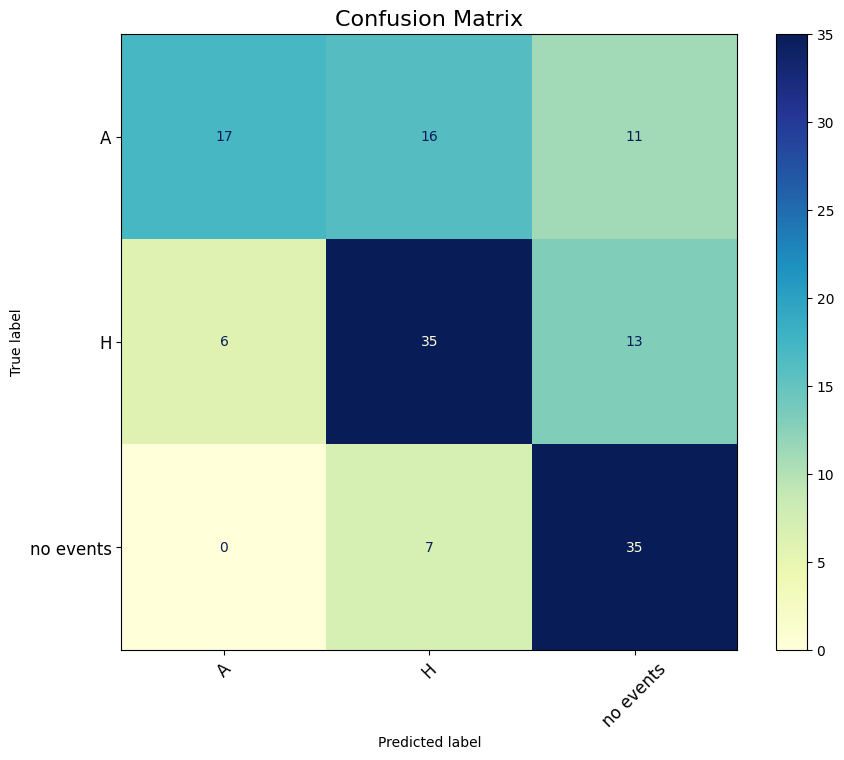

In [161]:
plot_confusion_matrix(model, test_loader, class_names=['A', 'H', 'no events'])

#### LOOCV
----

In [ ]:
LEARNING_RATE = 0.001
BATCH_SIZE = 32
T_MAX = 50
ETA_MIN = 1e-6
EPOCHS = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model_class = TCNModel
model_params = {"n_length": 375, "n_features": 4, "n_outputs": 3}

# Call train_with_loocv
history = train_with_loocv(
    model_class=model_class,
    model_params=model_params,
    dataset=event_classification_dataset,
    batch_size=BATCH_SIZE,
    criterion=kl_divergence_loss,
    optimizer_class=torch.optim.Adam,
    optimizer_params={"lr": LEARNING_RATE},
    max_fold=2,
    scheduler_class=torch.optim.lr_scheduler.CosineAnnealingLR,
    scheduler_params={"T_max": T_MAX, "eta_min": ETA_MIN},
    epochs=EPOCHS,
    device=DEVICE,
    early_stopping=False,  # Set to True if you want early stopping
    patience=20,  # Adjust patience if early stopping is enabled
    verbose=True
)

In [64]:
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation_rate):
        super(TCNBlock, self).__init__()

        self.conv1 = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            padding='same',
            dilation=dilation_rate
        )
        self.batch_norm = nn.BatchNorm1d(out_channels)

        # Residual connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = None

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.batch_norm(out)

        shortcut = self.shortcut(x) if self.shortcut is not None else x
        return F.relu(out + shortcut)

class TCNModel(nn.Module):
    def __init__(self, n_length, n_features, n_outputs):
        super(TCNModel, self).__init__()

        self.tcn_blocks = nn.Sequential(
            TCNBlock(n_features, 32, kernel_size=3, dilation_rate=1),
            TCNBlock(32, 64, kernel_size=3, dilation_rate=2),
            TCNBlock(64, 128, kernel_size=3, dilation_rate=4),
            TCNBlock(128, 256, kernel_size=3, dilation_rate=8)
        )

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, n_outputs)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (batch_size, n_features, n_length)
        x = self.tcn_blocks(x)

        x = self.global_avg_pool(x).squeeze(-1)  # Global average pooling

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return F.softmax(x, dim=1)

In [65]:
best_model = TCNModel(n_length=n_timesteps, n_features=n_features, n_outputs=2).to(device)
# best_model.load_state_dict(torch.load('/kaggle/input/sleep_event_classification/pytorch/1/1/best_model_29122024_2310_A9574_Rest_on_kaggle.pth', weights_only = True))
best_model.load_state_dict(torch.load('/kaggle/input/sleep_event_classification/pytorch/1/1/best_model_29122024_1948_A9166_P9458_R8722_S9559.pth', weights_only = True))
# best_model = model
best_model.eval();

In [66]:
val_correct = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
    
        outputs = best_model(inputs)
        val_correct += (outputs.argmax(1) == targets.argmax(1)).sum().item()
    print(f"val_acc: {val_correct/len(test_loader.dataset)}")

val_acc: 0.9684896776530243


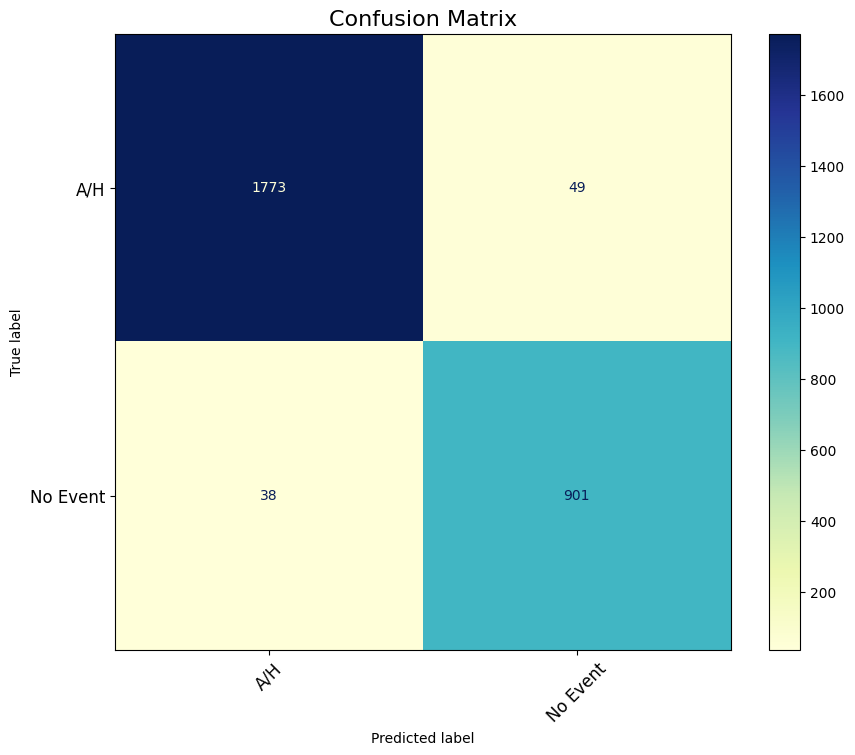

In [68]:
plot_confusion_matrix(best_model, test_loader, class_names=["A/H", "No Event"])

In [72]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Confusion matrix values from the image
confusion_matrix_values = np.array([
    [1773, 49],  # True apnea
    [38, 901]  # True hypopnea
   # True no events
])

# Extract individual values
true_positives = np.diag(confusion_matrix_values)  # Diagonal elements (TPs for each class)
total_samples = confusion_matrix_values.sum()     # Total number of samples
false_positives = confusion_matrix_values.sum(axis=0) - true_positives  # Column-wise sum minus TP
false_negatives = confusion_matrix_values.sum(axis=1) - true_positives  # Row-wise sum minus TP
true_negatives = total_samples - (false_positives + false_negatives + true_positives)  # Rest

# Calculate metrics per class
precision_per_class = true_positives / (true_positives + false_positives)
recall_per_class = true_positives / (true_positives + false_negatives)
f1_score_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)

# Handle NaN cases (e.g., division by zero)
precision_per_class = np.nan_to_num(precision_per_class)
recall_per_class = np.nan_to_num(recall_per_class)
f1_score_per_class = np.nan_to_num(f1_score_per_class)

# Overall metrics
accuracy = true_positives.sum() / total_samples
macro_precision = precision_per_class.mean()
macro_recall = recall_per_class.mean()
macro_f1 = f1_score_per_class.mean()

# Classification report
# y_true = np.repeat([0, 1, 2], confusion_matrix_values.sum(axis=1))  # True labels
y_true = np.repeat([0, 1], confusion_matrix_values.sum(axis=1))  # True labels
# y_pred = np.hstack([[i] * confusion_matrix_values[i, j] for i in range(3) for j in range(3)])  # Predicted labels
y_pred = np.hstack([[i] * confusion_matrix_values[i, j] for i in range(2) for j in range(2)])  # Predicted labels

# report = classification_report(y_true, y_pred, target_names=["apnea", "hypopnea", "no events"], output_dict=True)
report = classification_report(y_true, y_pred, target_names=["A/H", "no events"], output_dict=True)

# Summarize results
results = {
    "Accuracy": accuracy,
    "Precision (per class)": precision_per_class,
    "Recall (per class)": recall_per_class,
    "F1-score (per class)": f1_score_per_class,
    "Macro Precision": macro_precision,
    "Macro Recall": macro_recall,
    "Macro F1": macro_f1,
    "Classification Report": report
}

results


{'Accuracy': 0.9684896776530243,
 'Precision (per class)': array([0.97901712, 0.94842105]),
 'Recall (per class)': array([0.97310648, 0.95953142]),
 'F1-score (per class)': array([0.97605285, 0.95394389]),
 'Macro Precision': 0.9637190851230782,
 'Macro Recall': 0.9663189463999935,
 'Macro F1': 0.9649983672695019,
 'Classification Report': {'A/H': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 1822},
  'no events': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 939},
  'accuracy': 1.0,
  'macro avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 2761},
  'weighted avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 2761}}}

# TSFEL
----

In [ ]:
class EvtClassSetForTSFEL(Dataset):
    def __init__(self, root_dir, transform=None, label_mapping=None, included_classes=None):
        """
        Args:
            root_dir (str): Root directory containing all folders and signal files.
            transform (callable, optional): Optional transform to apply to the signals.
            included_classes (list, optional): List of classes to include. If None, include all classes.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.included_classes = included_classes
        self.label_mapping = label_mapping
        self.data_info = self._prepare_file_list()

    def _prepare_file_list(self):
        """Scan the dataset directory and prepare a list of file paths and labels."""
        data_info = []

        # Process Event files
        upper_limit_per_event = {
            'oa': -1,
            'ca': -1,
            'oh': -1,
            'mh': -1,
            'ch': -1
        }
        
        current_count = {
            'oa': 0,
            'ca': 0,
            'oh': 0,
            'mh': 0,
            'ch': 0
        }
        expert = ['1', '2']
        
        selected_patients = {
            'S1': ['1_1', '2_1', '3_1', '5_1', '6_1', '7_1', '8_1', '10_1', '11_1', '12_1', '13_1', '14_1', '15_1', '16_1', 
                   '18_1', '19_1', '20_1', '21_1', '22_1', '23_1', '24_1', '26_1', '27_1', '28_1', '29_1', '30_1', '31_1', 
                   '33_1', '34_1', '35_1', '36_1', '37_1', '39_1', '40_1', '41_1', '43_1', '44_1', '45_1', '46_1', '47_1', '48_1', 
                   '49_1', '50_1', '51_1', '52_1', '54_1', '55_1', '56_1', '57_1', '59_1', '61_1', '62_1', '63_1', '65_1', '66_1', 
                   '67_1', '68_1', '69_1', '70_1', '72_1', '73_1', '74_1', '75_1', '76_1', '77_1', '78_1', '80_1', '81_1', '82_1', 
                   '83_1', '84_1', '85_1', '86_1', '87_1', '88_1', '89_1', '91_1', '92_1', '93_1', '94_1', '95_1', '96_1', '97_1', '99_1'],
            'S2': ['1_1', '1_2', '2_2', '3_1', '3_2', '5_1', '5_2', '6_2', '7_1', '8_1', '8_2'],
            'S3': ['1_1', '2_1', '3_1', '4_1', '5_1', '6_1', '7_1', '8_1', '9_1', '10_1']
        }

        upper_limit_to_no_events = 6000
        
        event_path = os.path.join(self.root_dir, 'Events')
        if os.path.isdir(event_path):
            for label_folder in os.listdir(event_path):
                if self.included_classes and label_folder not in self.included_classes:
                    continue

                label_path = os.path.join(event_path, label_folder)
                if os.path.isdir(label_path):
                    for file_name in os.listdir(label_path):
                        # Full file path
                        file_path = os.path.join(label_path, file_name)

                        # Append (file_path, label) tuple
                        if upper_limit_per_event[label_folder] != -1 and current_count[label_folder] == upper_limit_per_event[label_folder]:
                            continue
                        else:
                            current_count[label_folder] += 1

                        # Extracting info from the file_name
                        parts = file_name.split('_')
                        
                        # Extract integers from parts that do not start with "Stage"
                        ints = [re.findall(r'\d+', part) for part in parts if not part.startswith('Stage')]
                        
                        # Flatten the list of lists and convert to integers
                        ints = [int(num) for sublist in ints for num in sublist]

                        # ints = [Subgroup, PatientID, ExpertNum, EventNum, SessionNum]
                        # ints[1]+'_'+str(ints[4]) -> ID_Session
                        if str(ints[1])+'_'+str(ints[4]) not in selected_patients['S'+str(ints[0])]:
                            continue

                        if str(ints[2]) not in expert:
                            continue
                        
                        data_info.append((file_path, label_folder, ints))

        # Process Non Event files
        non_event_path = os.path.join(self.root_dir, 'Non_Events')
        if os.path.isdir(non_event_path):
            for subfolder_name in os.listdir(non_event_path):
                subfolder_path = os.path.join(non_event_path, subfolder_name)
                if os.path.isdir(subfolder_path):
                    for file_name in os.listdir(subfolder_path):
                        # Full file path
                        file_path = os.path.join(subfolder_path, file_name)

                        if upper_limit_to_no_events == 0:
                            break
                        upper_limit_to_no_events -= 1

                        # Extracting info from the file_name
                        parts = file_name.split('_')
                        
                        # Extract integers from parts that do not start with "Stage"
                        ints = [re.findall(r'\d+', part) for part in parts if not part.startswith('Stage')]
                        
                        # Flatten the list of lists and convert to integers
                        ints = [int(num) for sublist in ints for num in sublist]

                        # Label for non-events is "no_event"
                        if not self.included_classes or 'no_event' in self.included_classes:
                            data_info.append((file_path, 'no_event', ints))

        return data_info

    def __len__(self):
        return len(self.data_info)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get file path and label
        file_path, label, ints = self.data_info[idx]
        patient_id = (ints[0], ints[1])

        # Convert label to one-hot encoding
        unique_labels = self.included_classes if self.included_classes else ['ar', 'awake', 'ca', 'ch', 'l on', 'l out', 
                                                                             'lm', 'mchg', 'mh', 'oa', 'oh', 'plm', 'rem', 
                                                                             'no_event']
        label_to_one_hot = {label: [1 if i == idx else 0 for i in range(len(unique_labels))] 
                            for idx, label in enumerate(unique_labels)}
        label = label_to_one_hot[label]

        possible_columns = [
        ['X6', 'X7', 'X8', 'SaO2'],
        ['X6', 'X7', 'X8', 'SpO2'],
        ['29', '30', '31', 'SaO2'],
        ['29', '30', '31', 'SpO2']
        ]
        
        signal = pd.read_csv(file_path)
    
        for columns in possible_columns:
            if all(col in signal.columns for col in columns):
                signal = signal[columns]
                break
        
        signal = torch.tensor(signal.values, dtype=torch.float32).T
        if self.label_mapping:
            label = self.label_mapping[np.argmax(label)]
        label = torch.tensor(label, dtype=torch.long)
        
        if self.transform:
            for transform in self.transform:
                signal = transform(signal)

        return signal.T, label, patient_id

In [ ]:
def split_by_patient(dataset):
    patient_ids = [patient_id for _, _, patient_id in dataset]
    unique_patients = list(set(patient_ids))
    
    # Split patients into train and test sets
    train_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)
    
    train_data = []
    test_data = []
    
    # Allocate data based on the patient split
    for idx, (_, _, patient_id) in enumerate(dataset):
        if patient_id in train_patients:
            train_data.append(idx)
        else:
            test_data.append(idx)
    
    return train_data, test_data

----

In [ ]:
# !pip install tsfel

cfg = tsfel.get_features_by_domain()  # Default configuration

In [ ]:
root_dir = '/kaggle/input/isruc-processed/dataset'
included_classes = ['ca', 'oa', 'oh', 'mh', 'ch', 'no_event']

filters = {
            0: (0.1, 0.5),  # AirFlow: 0.1–0.5 Hz
            1: (0.1, 0.5),  # Thoracic Respiration: 0.1–0.5 Hz
            2: (0.1, 0.5),  # Thoracic Respiration: 0.1–0.5 Hz
            3: (0.05, 2.0), # SpO2: 0.05–2.0 Hz
        }
transform = [BandpassFilter(fs=12.5, filters=filters), Normalization(method="custom", axis=1)]

event_classification_dataset_tsfel = EvtClassSetForTSFEL(root_dir=root_dir, transform=transform, included_classes=included_classes)
train_data, test_data = split_by_patient(event_classification_dataset_tsfel)

In [ ]:
train_subset = torch.utils.data.Subset(event_classification_dataset_tsfel, train_data)
test_subset = torch.utils.data.Subset(event_classification_dataset_tsfel, test_data)

In [ ]:
print(f"Train Subset length: {len(train_subset)}")
print(f"Test Subset length: {len(test_subset)}")

In [ ]:
all_features = []
all_labels = []

for signals, labels, _ in train_subset:
    channel_features = []
    
    for channel in range(signals.shape[1]):  # Iterate over channels
        # Extract a single channel
        signal_channel = signals[:, channel].numpy()  # Shape: (375,)
        
        # Convert signal to Pandas Series (TSFEL requires this format)
        signal_series = pd.Series(signal_channel)
        
        # Extract features for the current channel
        features = tsfel.time_series_features_extractor(cfg, signal_series, fs=12.5, verbose=0)
        
        # Append the flattened feature values
        channel_features.append(features.values.flatten())
    
    # Concatenate features from all channels for this signal
    combined_features = np.concatenate(channel_features)
    all_features.append(combined_features)
    
    # Store the corresponding label
    all_labels.append(labels.argmax().item())

In [ ]:
# Convert to NumPy arrays
feature_matrix = np.array(all_features)
label_array = np.array(all_labels)

print("Feature Matrix Shape:", feature_matrix.shape)
print("Labels Shape:", label_array.shape)

In [ ]:
# Save as a CSV
np.savetxt("train_features.csv", feature_matrix, delimiter=",")
np.savetxt("train_labels.csv", label_array, delimiter=",")

# Or save using Pandas
pd.DataFrame(feature_matrix).to_csv("train_features.csv", index=False)
pd.DataFrame(label_array, columns=["label"]).to_csv("train_labels.csv", index=False)

## Log
----

3-class - total => [160, 160, 107, 107, 107, 321] <-> test => ['A': 15, 'H': 13, 'N': 19] -> 90-95% 

